<a href="https://colab.research.google.com/github/KhanhPham2411/how_to_generate_video/blob/master/dog/dogs_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pickle
import os

In [0]:
from __future__ import print_function

from keras import backend as K

# https://stackoverflow.com/questions/57797113/attributeerror-module-keras-backend-has-no-attribute-image-dim-ordering
# image_dim_ordering change to image_data_format from Keras 2.x
# K.set_image_dim_ordering('th') # ensure our dimension notation matches
# https://github.com/keras-team/keras/issues/12649#issuecomment-615132968
K.set_image_data_format('channels_first')

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, AveragePooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD, Adam
from keras.datasets import mnist
from keras import utils
import numpy as np
from PIL import Image, ImageOps
import argparse
import math

import os
import os.path

import glob

In [10]:
# https://github.com/keras-team/keras/issues/13684#issuecomment-595054461 - experimental_list_devices in tensorflow_backend.py
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf


#Data

In [11]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O ./cats_and_dogs_filtered.zip

--2020-06-04 17:26:38--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M   117MB/s    in 0.6s    

2020-06-04 17:26:39 (117 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
main_folder = './'
!unzip -q cats_and_dogs_filtered.zip -d $main_folder

In [13]:
cd cats_and_dogs_filtered

/content/cats_and_dogs_filtered


In [0]:
!mkdir generated-images

In [0]:
train_folder = './train'

In [0]:
train_generator = ImageDataGenerator()

In [0]:
# https://stackoverflow.com/questions/6996603/how-to-delete-a-file-or-folder
import shutil
shutil.rmtree("train/cats")

In [18]:
generated_train_data = train_generator.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 128,
    class_mode = 'binary'
)

Found 1000 images belonging to 1 classes.


#Model definition

In [0]:
def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, output_dim=1024))
    model.add(Activation('tanh'))
    model.add(Dense(128*8*8))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Reshape((128, 8, 8), input_shape=(128*8*8,)))
    model.add(UpSampling2D(size=(4, 4)))
    model.add(Convolution2D(64, 5, 5, border_mode='same'))
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(4, 4)))
    model.add(Convolution2D(1, 5, 5, border_mode='same'))
    model.add(Activation('tanh'))
    return model


def discriminator_model():
    model = Sequential()
    model.add(Convolution2D(
                        64, 5, 5,
                        border_mode='same',
                        input_shape=(1, 128, 128)))
    model.add(Activation('tanh'))
    model.add(AveragePooling2D(pool_size=(4, 4)))
    model.add(Convolution2D(128, 5, 5))
    model.add(Activation('tanh'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model


def generator_containing_discriminator(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

In [0]:
def load_data(pixels=128, verbose=False):
    print("Loading data")
    X_train = []
    paths = glob.glob(os.path.normpath(os.getcwd() + '/train/dogs/*.jpg'))
    for path in paths:
        if verbose: print(path)
        im = Image.open(path)
        im = ImageOps.fit(im, (pixels, pixels), Image.ANTIALIAS)
        im = ImageOps.grayscale(im)
        im = np.asarray(im)
        
        X_train.append(im)
    print("Finished loading data")
    return np.array(X_train)

def load_image_path(path, pixels=128, verbose=False):
    if verbose: print(path)
    im = Image.open(path)
    im = ImageOps.fit(im, (pixels, pixels), Image.ANTIALIAS)
    im = ImageOps.grayscale(im)
    im = np.asarray(im)

    return im

#Model processing

In [0]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[2:]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[0, :, :]
    return image

In [0]:
model = generator_model()
print(model.summary())

In [0]:
def train(epochs, BATCH_SIZE, weights=False):
    """
    :param epochs: Train for this many epochs
    :param BATCH_SIZE: Size of minibatch
    :param weights: If True, load weights from file, otherwise train the model from scratch. 
    Use this if you have already saved state of the network and want to train it further.
    """
    X_train = load_data()
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    X_train = X_train.reshape((X_train.shape[0], 1) + X_train.shape[1:])
    discriminator = discriminator_model()
    generator = generator_model()
    if weights:
        generator.load_weights('goodgenerator.h5')
        discriminator.load_weights('gooddiscriminator.h5')
    discriminator_on_generator = \
        generator_containing_discriminator(generator, discriminator)
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    generator.compile(loss='binary_crossentropy', optimizer="SGD")
    discriminator_on_generator.compile(
        loss='binary_crossentropy', optimizer=g_optim)
    discriminator.trainable = True
    discriminator.compile(loss='binary_crossentropy', optimizer=d_optim)
    noise = np.zeros((BATCH_SIZE, 100))
    for epoch in range(epochs):
        print("Epoch is", epoch)
        print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            for i in range(BATCH_SIZE):
                noise[i, :] = np.random.uniform(-1, 1, 100)
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = generator.predict(noise, verbose=0)
            #print(generated_images.shape)
            if index % 20 == 0 and epoch % 10 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                destpath = os.path.normpath(os.getcwd()+ "/generated-images/"+str(epoch)+"_"+str(index)+".png")
                Image.fromarray(image.astype(np.uint8)).save(destpath)
            X = np.concatenate((image_batch, generated_images))
            y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
            d_loss = discriminator.train_on_batch(X, y)
            print("batch %d d_loss : %f" % (index, d_loss))
            for i in range(BATCH_SIZE):
                noise[i, :] = np.random.uniform(-1, 1, 100)
            discriminator.trainable = False
            g_loss = discriminator_on_generator.train_on_batch(
                noise, [1] * BATCH_SIZE)
            discriminator.trainable = True
            print("batch %d g_loss : %f" % (index, g_loss))
            if epoch % 10 == 9:
                generator.save_weights('goodgenerator.h5', True)
                discriminator.save_weights('gooddiscriminator.h5', True)

def clean(image):
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if image[i][j] + image[i+1][j] + image[i][j+1] + image[i-1][j] + image[i][j-1] > 127 * 5:
                image[i][j] = 255
    return image
def generate(BATCH_SIZE):
    generator = generator_model()
    generator.compile(loss='binary_crossentropy', optimizer="SGD")
    generator.load_weights('goodgenerator.h5')
    noise = np.zeros((BATCH_SIZE, 100))
    a = np.random.uniform(-1, 1, 100)
    b = np.random.uniform(-1, 1, 100)
    grad = (b - a) / BATCH_SIZE
    for i in range(BATCH_SIZE):
        noise[i, :] = np.random.uniform(-1, 1, 100)
    generated_images = generator.predict(noise, verbose=1)
    #image = combine_images(generated_images)
    print(generated_images.shape)
    for image in generated_images:
        image = image[0]
        image = image*127.5+127.5
        Image.fromarray(image.astype(np.uint8)).save("dirty.png")
        Image.fromarray(image.astype(np.uint8)).show()
        clean(image)
        image = Image.fromarray(image.astype(np.uint8))
        image.show()        
        image.save("clean.png")


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--mode", type=str)
    parser.add_argument("--batch_size", type=int, default=128)
    parser.add_argument("--nice", dest="nice", action="store_true")
    parser.set_defaults(nice=False)
    args = parser.parse_args()
    return args


In [0]:
train(400, 100, False)

In [38]:
generate(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=1024)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (5, 5), padding="same")`
  del sys.path[0]


1/1 [==============================] - 0s 27ms/step
(1, 1, 128, 128)


#Application

Saving cat.jpg to cat (1).jpg


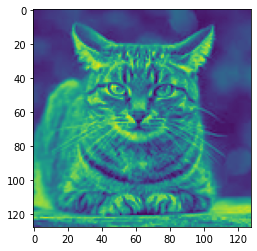

[0.49170125]
cat.jpg is a cat


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(1, 128, 1..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5))`


In [37]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
for fn in uploaded.keys():
    path = './' + fn

    # img = image.load_img(path, target_size = (150, 150))
    img = load_image_path(path)

    imgplot = plt.imshow(img)
    plt.show()
    x = (image.img_to_array(img) - 127.5)/127.5

    x = np.expand_dims(x, axis = 0)

    images = np.vstack([x])
    model = discriminator_model()
    model.load_weights('gooddiscriminator.h5')
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if(classes[0] > 0.5):
        print(fn + " is a dog")
    else:
        print(fn + " is a cat")